#### Capstone Project Report: 
# House Prices: Advanced Regression Techniques
Data is aquired from Kaggle. https://www.kaggle.com/c/house-prices-advanced-regression-techniques

##  Outline:
#### This capstone project report includes the following sections
#### 1. Data Introduction
#### 2. Data Importing and Cleaning
#### 3. Data Study
#### 4. Modeling

## 1. Data Introduction
Data is aquired from a competition on Kaggle. https://www.kaggle.com/c/house-prices-advanced-regression-techniques
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges competitors to predict the final price of each home.

## 2. Data Importing and Cleaning

### 2.1 Read in the training dataset of house pricing, and take a brief look of the data

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pprint
import scipy.stats as stats
%matplotlib inline

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


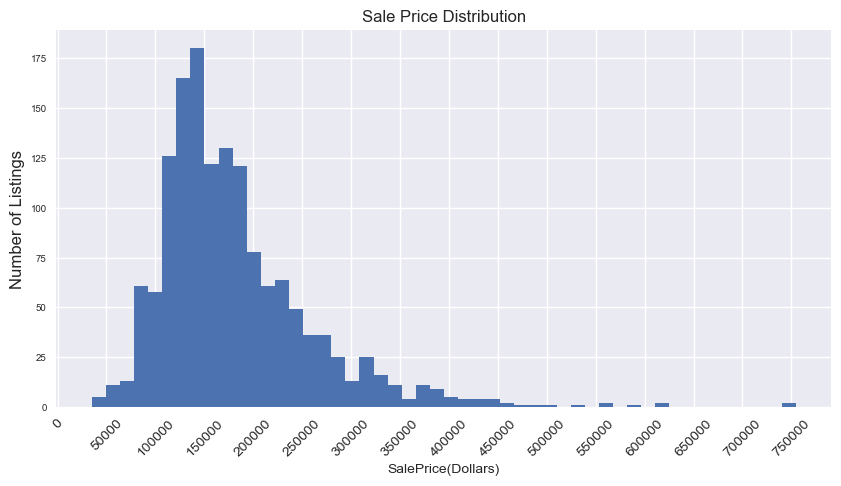

In [97]:
fig=plt.figure(figsize=(10, 5),dpi=100, facecolor='w', edgecolor='k' )
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}
df = pd.read_csv('train.csv')
ax = df['SalePrice'].hist(bins=50)
# ax.set_ylabel('Number of Passengers')
plt.xticks(np.arange(0,800000,50000),rotation=45,fontsize=10)
ax.set_xlabel('SalePrice(Dollars)',fontsize=10)
ax.set_ylabel('Number of Listings',fontsize=12)
ax.set_title('Sale Price Distribution',fontsize=12)
pd.DataFrame(df['SalePrice'].describe())

#### In the brief description of the whole dataset, we can see in the 1460 houses, the mean value of the sale prices is 180921 USD, while the cheapest one is only 34900 USD and the most expensive one is 757000 USD.

#### The total distribution of Number of Listed Houses VS Their Prices is demonstrated in the histogram above. It is quite obvious that the distribution is skewed to the cheaper side.

### 2.2 Clean data

#### 2.2.1 Remove features with too many Null values
When we take closer look for the description of all the features, we can notice there are several features in the dataset have too many Null values. Instead of making contributions, they are more likely cause troubles to the model training and sale price prediction.  These features will be removed from the dataset for better statistical analysis.
- 'Alley':            91 non-null object
- 'PoolQC':           7  non-null object
- 'MiscFeature':      54 non-null object
- 'FireplaceQu':      770 non-null object
- 'Fence':            281 non-null object

#### 2.2.2 Let's take a look on their correlation with saleprice in the boxplot shown in the boxplots below

(0.0, 1.0, 0.0, 1.0)

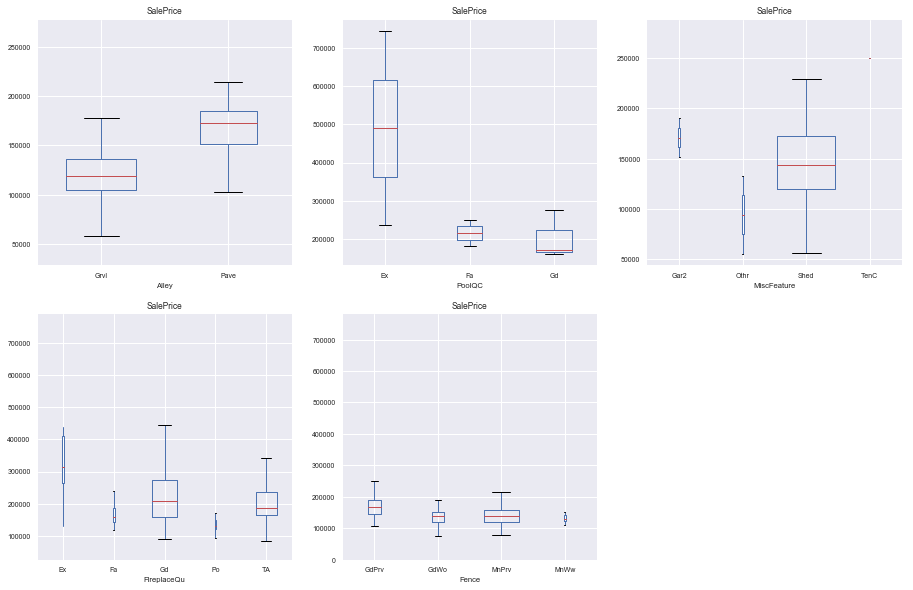

In [98]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(15,10))
sizes_alley = df.groupby('Alley').count().Id
sizes_alley = (sizes_alley/sum(sizes_alley)).tolist()
df.boxplot(ax = axes[0,0],column=['SalePrice'],by = 'Alley',widths = sizes_alley)
plt.ylabel('SalePrice')
plt.suptitle("")

sizes_poolqc = df.groupby('PoolQC').count().Id
sizes_poolqc = (sizes_poolqc/sum(sizes_poolqc)).tolist()
df.boxplot(ax = axes[0,1],column=['SalePrice'],by = 'PoolQC',widths = sizes_poolqc)
plt.ylabel('SalePrice')
plt.suptitle("")

sizes_3 = df.groupby('MiscFeature').count().Id
sizes_3 = (sizes_3/sum(sizes_3)).tolist()
df.boxplot(ax = axes[0,2],column=['SalePrice'],by = 'MiscFeature',widths = sizes_3)
plt.ylabel('SalePrice')
plt.suptitle("")

sizes_4 = df.groupby('FireplaceQu').count().Id
sizes_4 = (sizes_4/sum(sizes_4)).tolist()
df.boxplot(ax = axes[1,0],column=['SalePrice'],by = 'FireplaceQu',widths = sizes_4)
plt.ylabel('SalePrice')
plt.suptitle("")

sizes_5 = df.groupby('Fence').count().Id
sizes_5 = (sizes_5/sum(sizes_5)).tolist()
ax = df.boxplot(ax = axes[1,1],column=['SalePrice'],by = 'Fence',widths = sizes_5)
# ax.set_ylabel('')
plt.suptitle("")

# remove the unused subplot axis
axes[-1, -1].axis('off')

#### We can see that some of the features to be removed also have obvious correlation with saleprice, but sadly we have to remove these features because of the small number of valid data.

In [99]:
df = df.drop(['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'],1)

### 2.3 In the meantime, the null values in all the other features will be filled with 0 for the convenience of data wrangling

In [100]:
df = df.fillna(0)

## 3. Data Study
### 3.1 Pire-wise correlation study
Before we study the correlation between all the house features and house price, we need to find out the features that are highly correlated to each other, and have only one of the correlated features left in the dataset. So that correlated features will not REPEATINGLY contribute to the price modeling. 

Text(0.5,1,'Column pairs with correlation coefficient higher than 0.5')

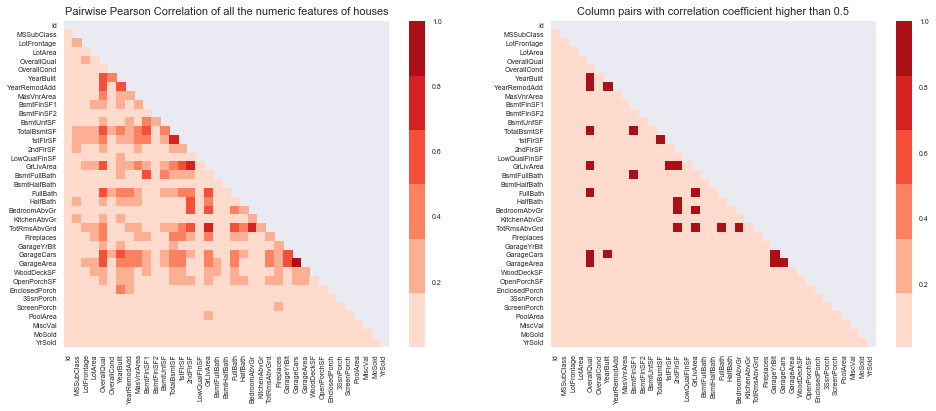

In [104]:
import seaborn as sns

df_no_SP = df.drop('SalePrice',axis=1)
corr_all = abs(df_no_SP.corr())


# Thresholding the correlations larger than 0.5 (or-0.5) 
corr_all_true = corr_all>0.5 
corr_all_true = corr_all_true

corr_dict = {}
for column in corr_all_true:
    corr_list = corr_all_true[column][corr_all_true[column]==True].index.tolist()
    corr_dict[column] = corr_list

# pprint.pprint(corr_dict)

# create custom color map
cmap = sns.color_palette("Reds")
fig1 = plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
# Generate a mask for the upper triangle
sns.set(font_scale=0.7)
mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_all, mask=mask, cmap=cmap,
          xticklabels=corr_all.columns.values,
          yticklabels=corr_all.columns.values)
plt.title('Pairwise Pearson Correlation of all the numeric features of houses',fontsize=11)


# fig2 = plt.figure()
plt.subplot(1,2,2)
sns.heatmap(corr_all_true,mask=mask,cmap=cmap,
           xticklabels=corr_all_true.columns.values,
           yticklabels=corr_all_true.columns.values,
           vmin=0.01,vmax=1)

plt.title('Column pairs with correlation coefficient higher than 0.5',fontsize=11)


- The heat map on the left is the pairwise pearson correlation for all the numeric features of houses. Dark red means high correlation, while the lighter red means lower correlation. We can see most features are coorelated to one or more features in some extant.

- To get the high related features with each other, we setup a threshold (here we use 0.5) to filter all the pearson scores higher than the threshold, and highlight them in the heatmap on the right.

- Now we remove some correlated columns by the code in the cell below, until no column is highly related to each other.

##### Note 1: only the columns with numeric values are kept after the corr_all = df_no_SP.corr(). So that we are only dealing with numeric features of the house for now.
##### Note 2: There are some features that is better to be kept----'YearBuilt' for sure. So we need to specify that in our columns list.

In [105]:
# Build a list of all the numeric column names for our dataframe, except SalePrice
num_cols_all = list(corr_all.columns)
# print(cols)
cols = num_cols_all

# See how many columns there are at first
len_1=len(num_cols_all)
removed_features=[]
# In the correlation dictionary, if the key is still in the columns_list, remove the items in the value from the columns_list that is not equal
# to the key itself.
for key, value in corr_dict.items():
    if key in cols:
        for feature in value:
            if (feature in cols) & (feature != key and feature != 'YearBuilt'):
                cols.remove(feature)
                removed_features.append(feature)
# Take a look how many features (columns) are removed from the last step.
len_2 = len(cols)

df = df.drop(removed_features,axis=1)
print('There are',len(removed_features),'features removed for high pairwise correlation:\n\n',removed_features)


There are 11 features removed for high pairwise correlation:

 ['YearRemodAdd', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'GarageCars', 'GarageArea', 'OverallQual', 'BsmtFullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd']


####  Run pairwise pearson correlation plot to confirm we have removed all the features with high pair-correlation

Text(0.5,1,'Pairwise Pearson Correlation of Remaining Numeric Features of Houses')

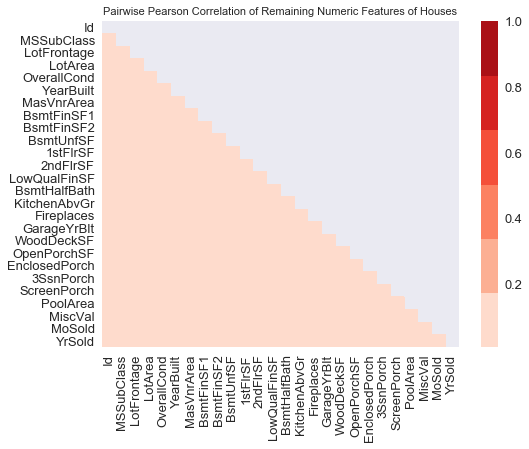

In [128]:
# select the dependent columns from previous DataFrame with no SalePrice, calculate the cross correlation, setup same threshold
# as before, and plot the heat map for the ture-false map. 
corr_no_repeat = abs(df[cols].corr())>0.5
# corr_no_repeat = abs(df[cols].corr())
fig3 = plt.figure(figsize=(8,6))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}
cmap = sns.color_palette("Reds")
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_no_repeat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_no_repeat, mask=mask,cmap=cmap,
          xticklabels=corr_no_repeat.columns.values,
          yticklabels=corr_no_repeat.columns.values,
          vmin=0.01,vmax=1)
sns.set(font_scale=1.3)
plt.title('Pairwise Pearson Correlation of Remaining Numeric Features of Houses',fontsize=11)

##### No more highly correlated features exist in the new dataframe `df` now.

### 3.2 Study the correlation between the top related numerical features and SalePrice
#### 3.2.1 plot ordered correlations with saleprice

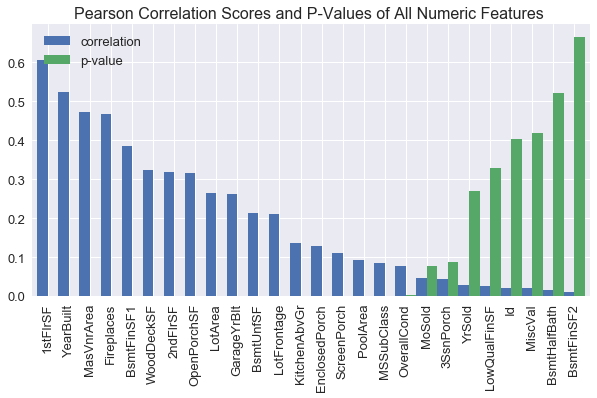

In [130]:
# Rebuild the numeric dataframe with SalePrice
num_cols = cols
num_df = df[num_cols]

pearson_dict={}
for col in num_df.columns:
    pearson_dict[col] = stats.pearsonr(df[col], df['SalePrice'])
# pprint.pprint(pear_dict)
pearson_df = pd.DataFrame(pearson_dict,index=['correlation','p-value'])
pearson_df=pearson_df.T.abs().sort_values(['correlation','p-value'],ascending=[False,True])
pearson_df.plot.bar(figsize=(10,5),fontsize=13,width=1)
plt.title('Pearson Correlation Scores and P-Values of All Numeric Features ',fontsize=16)
plt.legend(fontsize=13,loc = 2)

##### The above plot shows the correlation coefficients of features VS saleprice, from high to low for all the features. 
And the p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets, which means the lower p-value is, the better correlation is.

#### 3.2.2 Visualize the relation of the top 9 features with saleprice

#### Overall obseravtion for 9 features with highest correlation with saleprice

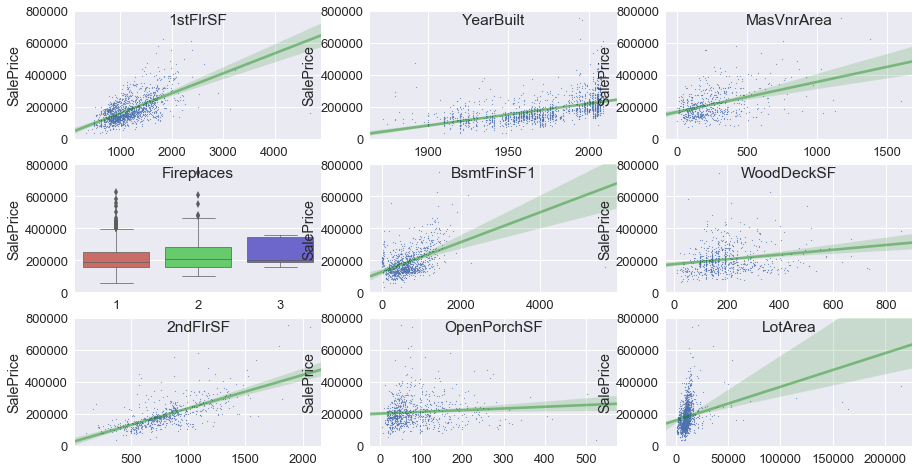

In [143]:
plt.fontsize=5
plt.figure(figsize=(15,8))
for i in range(9):
    name = pearson_df.index[i]
    plt.subplot(3,3,i+1)
    plt.ylim(0,800000)
    if df[name].unique().size>10:
        sns.regplot(x=name, y="SalePrice", data=df[df[name]>0],scatter_kws={"s": 1.5,'alpha':0.7},line_kws={'color':'g','alpha':0.4})
    else:
#         sns.regplot(x=name, y="SalePrice", data=df[df[name]>0],scatter_kws={"s": 1.5,'alpha':0.7},line_kws={'color':'g','alpha':0.4},x_estimator=np.mean)
        sns.boxplot(x=name, y='SalePrice',data=df[df[name]>0],palette='hls',linewidth=0.7)
    plt.title(name,y=0.85)
    plt.xlabel('')


# plt.subplot(3,3,6)
# plt.ylim(0,800000)
# sns.boxplot(num_df.Fireplaces,df.SalePrice)
# plt.title('Fireplaces')



##### All the 9 features are showing correlation with the saleprice, more or less. 
#### 3.2.3 Now Let's take a closer look at the top 3 features:
- 1stFlrSF (First Floor Square Feet)
- YearBuilt ( Original Construction Data)
- MasVnrArea (Masonry veneer area in square feet)

#### 1stFlrSF (First Floor Square Feet)
- First, we take a look at the histogram of 1stFlrSF, and we can see that most of the data is distributed between **[0,2500]**. 
- In order to get a better vision of relationship between 1stFlrSF and SalePrice, we plot for 1srFlrSF in **[0,2500]**

Text(0.5,0,'First Floor Square Feet')

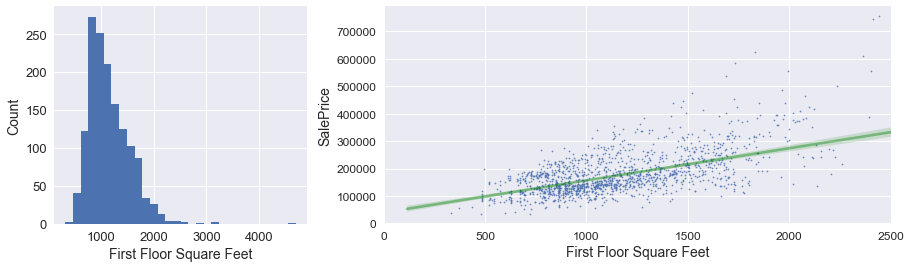

In [154]:
from matplotlib import gridspec
plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
plt.subplot(gs[0])
plt.hist(df['1stFlrSF'],bins=30)
plt.xlabel('First Floor Square Feet',fontsize=14)
plt.ylabel('Count',fontsize=14)

plt.subplot(gs[1])
# sns.regplot(x='1stFlrSF', y="SalePrice",x_bins=20, data=df,scatter_kws={"s": 1.5,'alpha':0.7},line_kws={'color':'g','alpha':0.4})
sns.regplot(x='1stFlrSF', y="SalePrice",data=df,robust=True,scatter_kws={"s": 3},line_kws={'color':'g','alpha':0.4})
plt.xlim([0,2500])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('SalePrice',fontsize=14)
plt.xlabel('First Floor Square Feet',fontsize=14)

#### Summary: 
For `1stFlrSF` in range of [0,2500], there is a clear correlation with `SalePrice`

#### YearBuilt (Original Construction Data)

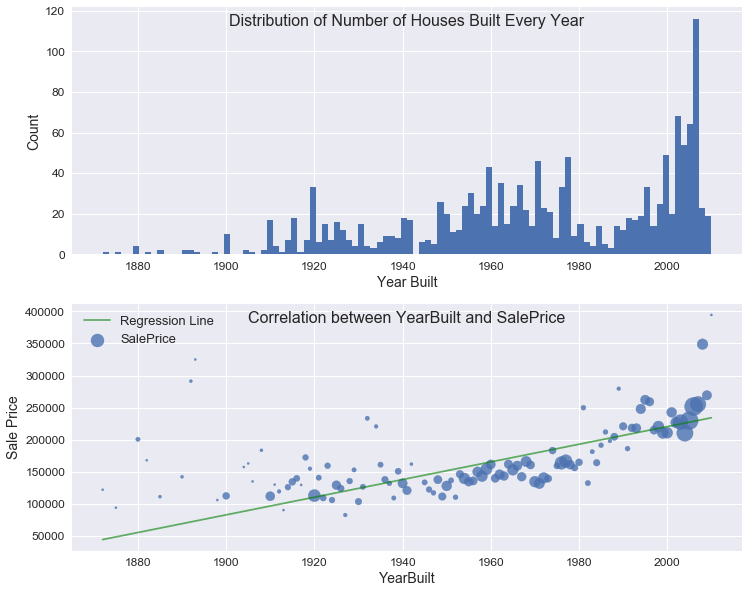

In [163]:
fig1 = plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.hist(df.YearBuilt,bins=100)
YearMean=df.groupby(['YearBuilt']).SalePrice.mean()
YearSize=df.groupby(['YearBuilt']).SalePrice.count()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Count',fontsize=14)
plt.xlabel('Year Built',fontsize=14)
plt.title('Distribution of Number of Houses Built Every Year',fontsize=16,y=0.9)

plt.subplot(2,1,2)
plt.scatter(YearMean.index,YearMean,s=YearSize*5,alpha=0.8)
# the regression line is created with all the original SalePrice, not the year-mean value
fit = np.polyfit(df.YearBuilt,df.SalePrice,deg=1)
plt.plot(YearMean.index, fit[0] * YearMean.index + fit[1], color='green',alpha=0.6)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Sale Price',fontsize=14)
plt.xlabel('YearBuilt',fontsize=14)
plt.title('Correlation between YearBuilt and SalePrice',fontsize=16,y=0.9)
plt.legend(['Regression Line','SalePrice'])

#### Summary: 
The histogram above shows the distribution of the built year of houses. And the scatter plot with regression line shows that there is clear correlation between `YearBuilt` and `SalePrice`. The y position of dots in the plot is the average SalePrice in that year, and **the size of dots mean the number for houses built in that year**.


#### MasVnrArea (Masonry veneer area in square feet)

Text(0.5,0,'Masonry Veneer Area in Square Feet')

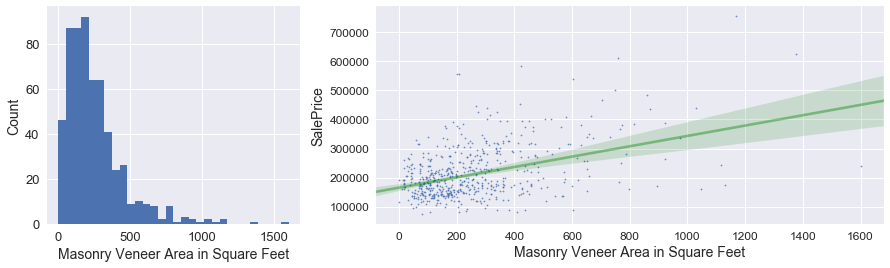

In [153]:
from matplotlib import gridspec
plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
plt.subplot(gs[0])
plt.hist(df[df.MasVnrArea>0].MasVnrArea,bins=30)
plt.xlabel('Masonry Veneer Area in Square Feet',fontsize=14)
plt.ylabel('Count',fontsize=14)

plt.subplot(gs[1])
# sns.regplot(x='1stFlrSF', y="SalePrice",x_bins=20, data=df,scatter_kws={"s": 1.5,'alpha':0.7},line_kws={'color':'g','alpha':0.4})
sns.regplot(x='MasVnrArea', y="SalePrice",data=df[df.MasVnrArea>0],robust=True,scatter_kws={"s": 3},line_kws={'color':'g','alpha':0.4})
# plt.xlim([0,1000])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('SalePrice',fontsize=14)
plt.xlabel('Masonry Veneer Area in Square Feet',fontsize=14)

#### Summary:

The histogram above shows the distribution of the `MasVnrArea`. And the scatter plot with regression line shows that there is clear correlation between `MasVnrArea` and `SalePrice`. 

#### From the analysis in this section, we reconfirmed the correlation between some top features and SalePrice by visualization in different ways. We are not going to focus on all the numerical features one by one. 

### 3.3 Study the correlation between the categorical features and SalePrice
##### Note: R_2 score is the proportion of variance in the dependent variable (science) which can be explained by the independent variable.
- prepare the categorical features
- rate the correlations of each features VS SalePrice and save in DataFrame
- Sort the features by r_2 scores from high to low. Show the result in a table and a barplot below.

In [158]:
from statsmodels.formula.api import ols

############### prepare categorical features#################### 
# cat_df: categorical data from original df
cat_df = df.drop(num_cols,axis=1).drop('SalePrice',axis=1)

############### Rate the correlation with R_2 sccore############
features_R = {}
for feature in cat_df.columns.values.tolist():
    model = ols('SalePrice ~'+feature, df).fit()
    features_R[feature] = model.rsquared

############### Sort the features by r_2 scores ################
r_df = pd.DataFrame(list(features_R.items()),columns=['features','R_squared']).sort_values(by=['R_squared'],ascending=False)
r_df.index = r_df['features']
r_df = r_df.drop('features',axis=1)

In [159]:
r_df.T

features,Neighborhood,ExterQual,BsmtQual,KitchenQual,GarageFinish,Foundation,GarageType,BsmtFinType1,HeatingQC,MasVnrType,...,BsmtFinType2,LandContour,ExterCond,LotConfig,Functional,Heating,Condition2,LandSlope,Street,Utilities
R_squared,0.545575,0.477388,0.464994,0.456599,0.305874,0.256368,0.249204,0.21081,0.1955,0.188823,...,0.030294,0.025794,0.023618,0.021019,0.01648,0.014437,0.009899,0.002682,0.001684,0.000205


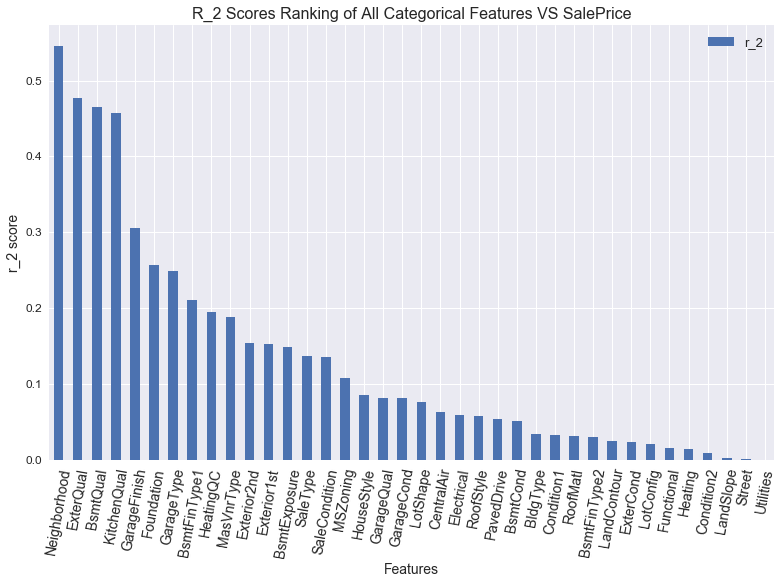

In [182]:
fig = plt.figure(figsize=(13,8))
# plt.bar(r_df.index,r_df.R_squared)
r_df.plot.bar(figsize=(13,8))
plt.title('R_2 Scores Ranking of All Categorical Features VS SalePrice',fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(rotation=80,fontsize=14)
plt.ylabel('r_2 score',fontsize=14)
plt.xlabel('Features',fontsize=14)
plt.legend(['r_2'])

#### Take a closer look at some top ranked features
- Neighborhood
- ExterQual
- BsmtQual

#### Neighborhood:

Text(0.5,0.98,'')

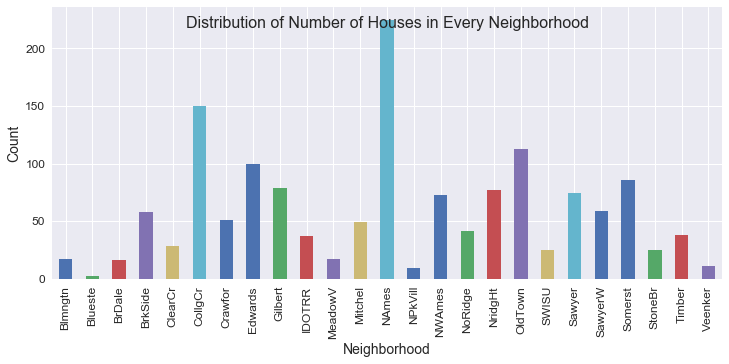

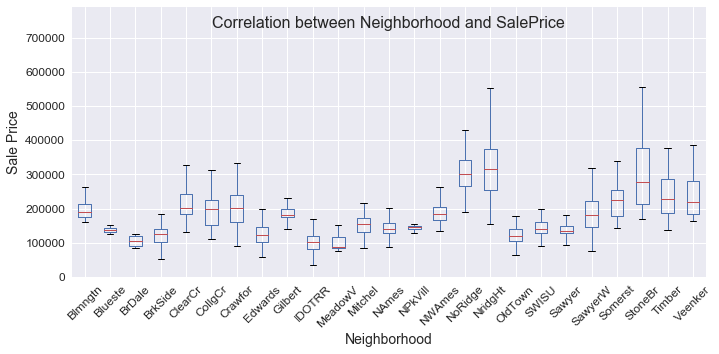

In [184]:
fig1 = plt.figure(figsize=(12,5))

ax = df.groupby('Neighborhood').count().Id.plot.bar()
# ax = df.groupby('Neighborhood').count().reset_index('count').sort_values('count').Id.plot.bar()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Count',fontsize=14)
plt.xlabel('Neighborhood',fontsize=14)
plt.title('Distribution of Number of Houses in Every Neighborhood',fontsize=16,y=0.9)

fig2 = plt.figure(figsize=(12,5))
ax = df.boxplot(column='SalePrice',by='Neighborhood',figsize=(11,5),rot=45)
# ax = df.groupby('Neighborhood').SalePrice.plot.box()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Sale Price',fontsize=14)
plt.xlabel('Neighborhood',fontsize=14)
plt.title('Correlation between Neighborhood and SalePrice',fontsize=16,y=0.9)
plt.suptitle('')

#### From the plot above, we can see that house price in some neighborhoods is higher or lower than others in general.

#### ExterQual:

Text(0.5,0.98,'')

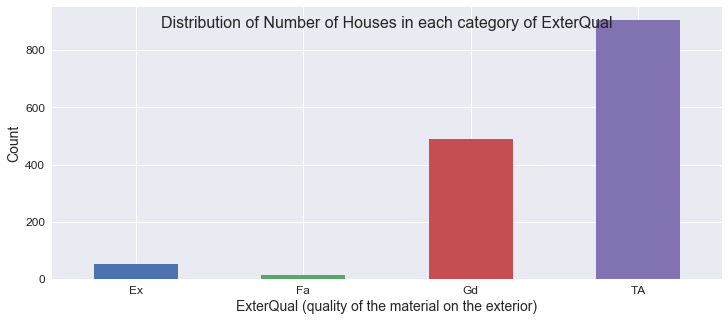

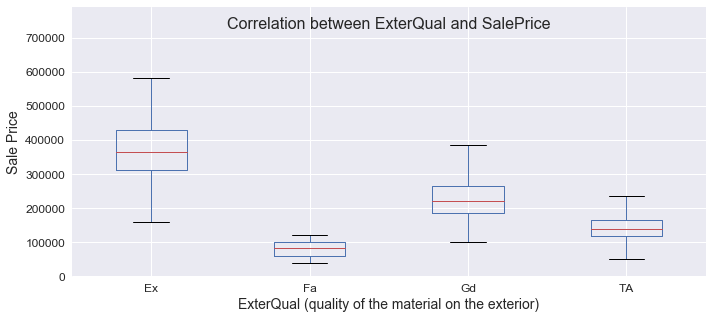

In [185]:
fig1 = plt.figure(figsize=(12,5))

ax = df.groupby('ExterQual').count().Id.plot.bar()
# ax = df.groupby('Neighborhood').count().reset_index('count').sort_values('count').Id.plot.bar()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12,rotation=0)
plt.ylabel('Count',fontsize=14)
plt.xlabel('ExterQual (quality of the material on the exterior)',fontsize=14)
plt.title('Distribution of Number of Houses in each category of ExterQual',fontsize=16,y=0.9)

fig2 = plt.figure(figsize=(12,5))
ax = df.boxplot(column='SalePrice',by='ExterQual',figsize=(11,5))
# ax = df.groupby('Neighborhood').SalePrice.plot.box()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Sale Price',fontsize=14)
plt.xlabel('ExterQual (quality of the material on the exterior)',fontsize=14)
plt.title('Correlation between ExterQual and SalePrice',fontsize=16,y=0.9)
plt.suptitle('')

#### From the plots above, it is obvious that houses in some ExterQual have higher price, and some have lower price.

#### BsmtQual:

Text(0.5,0.98,'')

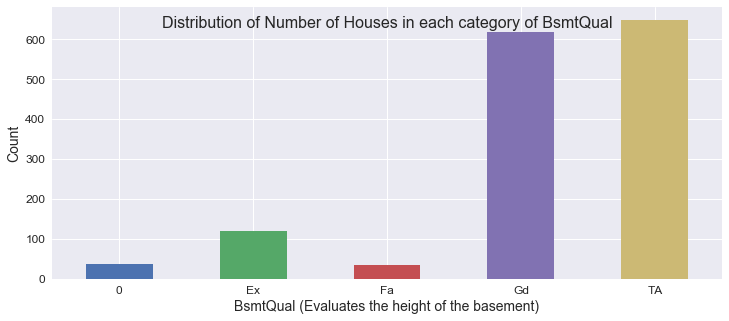

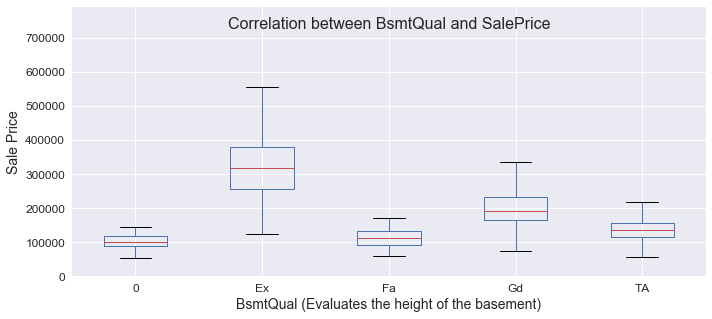

In [186]:
fig1 = plt.figure(figsize=(12,5))

ax = df.groupby('BsmtQual').count().Id.plot.bar()
# ax = df.groupby('Neighborhood').count().reset_index('count').sort_values('count').Id.plot.bar()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12,rotation=0)
plt.ylabel('Count',fontsize=14)
plt.xlabel('BsmtQual (Evaluates the height of the basement)',fontsize=14)
plt.title('Distribution of Number of Houses in each category of BsmtQual',fontsize=16,y=0.9)

fig2 = plt.figure(figsize=(12,5))
ax = df.boxplot(column='SalePrice',by='BsmtQual',figsize=(11,5))
# ax = df.groupby('Neighborhood').SalePrice.plot.box()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Sale Price',fontsize=14)
plt.xlabel('BsmtQual (Evaluates the height of the basement)',fontsize=14)
plt.title('Correlation between BsmtQual and SalePrice',fontsize=16,y=0.9)
plt.suptitle('')

#### From the plots above, it is obvious that houses in some BsmtQual have higher price, and some have lower price.

### 3.4 High correlated features:
Considering correlation(or r_squared)>0.05 as significant, the top numerical features and top categorical features are listed below, and we are going to use these `useful_features` for the following model training.

In [187]:
# absolute values >0.05
num_top_features = pearson_df[abs(pearson_df['correlation'])>0.05].index.values.tolist()
cat_top_features = r_df[abs(r_df['R_squared'])>0.05].index.values.tolist()
useful_features = num_top_features+cat_top_features
print(len(num_top_features),'numerical features:\n',num_top_features,'\n')
print(len(cat_top_features),'catigorical features:\n',cat_top_features)

18 numerical features:
 ['1stFlrSF', 'YearBuilt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea', 'GarageYrBlt', 'BsmtUnfSF', 'LotFrontage', 'KitchenAbvGr', 'EnclosedPorch', 'ScreenPorch', 'PoolArea', 'MSSubClass', 'OverallCond'] 

25 catigorical features:
 ['Neighborhood', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageFinish', 'Foundation', 'GarageType', 'BsmtFinType1', 'HeatingQC', 'MasVnrType', 'Exterior2nd', 'Exterior1st', 'BsmtExposure', 'SaleType', 'SaleCondition', 'MSZoning', 'HouseStyle', 'GarageQual', 'GarageCond', 'LotShape', 'CentralAir', 'Electrical', 'RoofStyle', 'PavedDrive', 'BsmtCond']


## 4. Modeling

### 4.1 Split our data into train data and test data
But before we do that, we need to prepare something first.
- Converts categorical variables into dummy variables.
- Change the scale of house prices into log scale.

Then we split data into train and test.

In [188]:
import numpy as np
from sklearn.cross_validation import train_test_split

def preprocess_features(X):
    # Initialize new output DataFrame(empty)
    output = pd.DataFrame(index = X.index)
    
    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        #print(col,col_data)

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output


# Keep only the useful features in X
df_featured = df[useful_features]
y = np.log(df.SalePrice)
X = df.loc[:,df_featured.columns != 'SalePrice']

# X_all is df all numeric, and no "SalePrice"
X_all = preprocess_features(X)
X_all.info()

# Split the targets into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.20, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 207 entries, Id to BsmtHalfBath
dtypes: float64(2), int64(12), uint8(193)
memory usage: 434.9 KB


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 4.2 Compare 3 machine learning models for price prediction with RepeatedKFold cross validation
Training data will be splited into 10 fragments, and each training-test pair will be tested 5 times

#### Linear Regression
- Linear regression is a linear model, e.g. a model that assumes a linear relationship between the input variables (x) and the single output variable (y). More specifically, that y can be calculated from a linear combination of the input variables (x).

- Linear regression will make more reliable predictions if the input and output variables have a Gaussian distribution. Using transforms (e.g. log or BoxCox) on variables may make their distribution more Gaussian looking.

- Limitations:
> 1. Linear regressions are sensitive to outliers.
> 2. It is easy to overfit our model such that the regression begins to model the random error (noise) in the data, rather than just the relationship between the variables.
> 3. Linear regressions are meant to describe linear relationships between variables. So, if there is a nonlinear relationship, then we will have a bad model.


#### Decision Tree Regression

- Decision Tree Regression
> Decision tree learning uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves). Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees.

- Advantage
> 1. Nonlinear relationships between parameters do not affect tree performance.
> 2. Simple to understand and interpret.
> 3. Able to handle both numerical and categorical data.
> 4. Performs well with large datasets.



- Disadvantage
> 1. Poor Resolution With Continuous Expectation Variables.
> 2. Trees can be very non-robust. A small change in the training data can result in a big change in the tree, and thus a big change in final predictions.

#### Random Forest Regression

- Random Forest Regression
> Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.

- Advantages
> 1. It runs efficiently on large databases.
> 2. It gives estimates of what variables are important in the classification.
> 3. It has an effective method for estimating missing data and maintains accuracy when a large proportion of the data are missing.
> 4. It can handle thousands of input variables without variable deletion.
> ...

- Disadvantages
> 1. It has been observed to overfit for some datasets with noisy tasks.
> 2. For data including categorical variables with different number of levels, random forest are biased in favor of those attributes with more levels. Therefore, the variable importance score from random forests are not reliable for this type of data.

In [193]:
from sklearn.metrics import r2_score
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
import time

kf = RepeatedKFold(n_splits=10,n_repeats=5)
model_scores={}
model_time={}
clfs={'tree':tree.DecisionTreeRegressor(),'frst':RandomForestRegressor(),'linear':LinearRegression()}

# try k-nearest neighbour(take all the data, define distance matrix), 
#     svr(looks for dimension of the data, find the plane that cut the data into different categories)

best_model_list=[]
score_df=pd.DataFrame()
time_df = pd.DataFrame()

############## Try the model_scoring for n times ##################
for train_index, test_index in kf.split(X_train):
    
    X_train_formodel,X_test_formodel = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_formodel,y_test_formodel = y_train.iloc[train_index], y_train.iloc[test_index]
    for model_name in clfs.keys():
        clf = clfs[model_name]
        time1 = time.time()
        clf=clf.fit(X_train_formodel,y_train_formodel)
        time2 = time.time()
        y_pred = clf.predict(X_test_formodel)
        score = r2_score(y_test_formodel, y_pred)
        model_scores[model_name]=score
        model_time[model_name]=time2-time1

    score_df=score_df.append(pd.DataFrame.from_dict(model_scores,orient='index').transpose())
    time_df=time_df.append(pd.DataFrame.from_dict(model_time,orient='index').transpose())
    
    max_value = max(model_scores.values()) 
    max_key   = [k for k, v in model_scores.items() if v == max_value][0]
    best_model_list.append(max_key)

best_model_count = {x:best_model_list.count(x) for x in set(best_model_list)}
print(best_model_count)

{'linear': 32, 'frst': 18}


#### In the 50 tests performed above, LinearRegressor won 32 times, RandomForestRegressor won 18 times, and DecisionTreeRegressor won 0.
| |Linear Regressor|Random Forest Regressor| Decision Tree Regressor|
|--|--|--|--|
|WINS|32|18|0|
#### However, when we plot the detail for all the test result, we see something more.

Text(0.5,0,'')

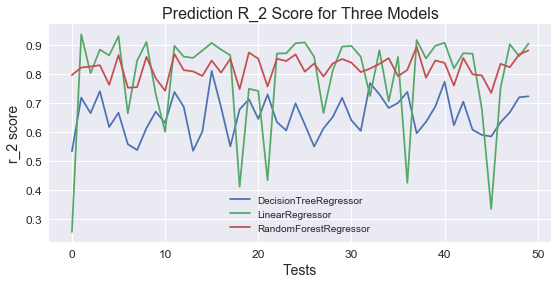

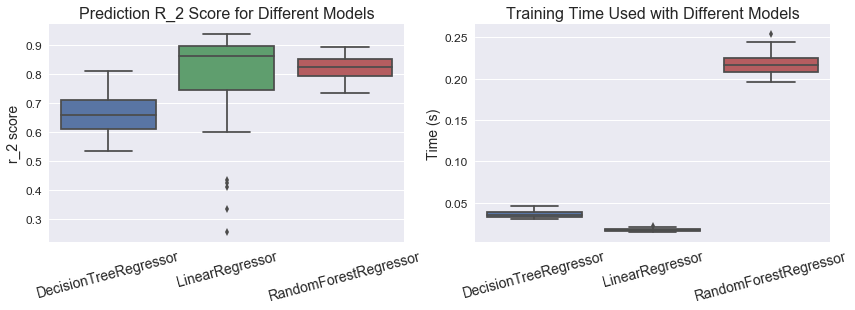

In [201]:

score_df.index = np.arange(score_df.index.shape[0])
score_df_true=score_df.loc[score_df['linear']>0]#remove the predictions from LinearRegresor that resulted in negetive score

############## Make line plot ###########
fig1 = plt.figure(figsize=(9,4))
plt.plot(score_df_true.tree)
plt.plot(score_df_true.linear)
plt.plot(score_df_true.frst)
plt.legend(['DecisionTreeRegressor','LinearRegressor','RandomForestRegressor'],fontsize=10)
plt.title('Prediction R_2 Score for Three Models',fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(rotation=0,fontsize=12)
plt.ylabel('r_2 score',fontsize=14)
plt.xlabel('Tests',fontsize=14)

############### Make boxplot#############
fig2 = plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
melted_df = pd.melt(score_df_true,value_vars=['tree','linear','frst'])
g=sns.boxplot(melted_df.variable,melted_df.value)
plt.title('Prediction R_2 Score for Different Models',fontsize=16)
# g.set_xticklabels(['DecisionTreeRegressor','LinearRegressor','RandomForestRegressor'])
g.set_xticklabels(['DecisionTreeRegressor','LinearRegressor','RandomForestRegressor'],fontsize=14,rotation=15)
# plt.xticks(['DecisionTreeRegressor','LinearRegressor','RandomForestRegressor'],fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('r_2 score',fontsize=14)
plt.xlabel('',fontsize=14)

plt.subplot(1,2,2)
melted_time = pd.melt(time_df,value_vars=['tree','linear','frst'])
g=sns.boxplot(melted_time.variable,melted_time.value)
plt.title('Training Time Used with Different Models',fontsize=16)
# g.set_xticklabels(['DecisionTreeRegressor','LinearRegressor','RandomForestRegressor'])
g.set_xticklabels(['DecisionTreeRegressor','LinearRegressor','RandomForestRegressor'],fontsize=14,rotation=15)
# plt.xticks(['DecisionTreeRegressor','LinearRegressor','RandomForestRegressor'],fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Time (s)',fontsize=14)
plt.xlabel('',fontsize=14)

In [370]:
score_df['frst'].mean(),score_df_true['linear'].mean()

(0.8130505539043678, 0.7884676652721158)

#### Result of Model Comparison:
- R_2 Score: In the boxplot analysis above, we can see `RandomForest` and `LinearRegressor` both have better overall performance than `DecisionTree`, obviously. The median of `LinearRegressor` is higher than `RandomForest`, but the mean score of `LinearRegressor` `0.7885` is lower that that of `RandomForest` `0.8130`. And the variance of `RamdomForest` is much smaller than `LinearRegresssor`, which is an obvious observation from the plot as well. In terms of r_2 score, **`RandomForestRegressor`** is the best model out of the three.
- Time: The training time consumed by `RandomForestRegressor` is much more than `DecisionTreeRegressor` and `LinearRegressor`. But in this project, we aim to get the best prediction, and longer model training time in an acceptable range is bearable.

##### We will use `RandomForestRegressor` as the chosen model for the following analysis.

### 4.3 Use all features or the significantly correlated ones only?
In the previous model scoreing, only the features classified as significant are used for the model training. In this section, we will test the score with all the features.

#### Prepare train and test data like we did in the previous section

In [202]:
import numpy as np
from sklearn.cross_validation import train_test_split

def preprocess_features(X):
    '''   converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''

    # Initialize new output DataFrame(empty)
    output = pd.DataFrame(index = X.index)
     
    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        #print(col,col_data)

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
#             print(col,'categorical')
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

# Use all the features 
y = np.log(df.SalePrice)
X = df.loc[:,df.columns != 'SalePrice']

# X_all is df all numeric, and no "SalePrice"
X_all = preprocess_features(X)
X_all.info()

# Split the targets into training/testing sets

X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.20, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 271 entries, Id to SaleCondition_Partial
dtypes: float64(3), int64(23), uint8(245)
memory usage: 646.0 KB


#### RepeatedKFold Cross Validation for the performance of RandomForestRegressor in the all-feature data

In [213]:
from sklearn.metrics import r2_score
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
import time

kf = RepeatedKFold(n_splits=10,n_repeats=5)
model_scores={}
frst_scores=[]
frst_time=[]

############## Try the model_scoring for n times ##################
for train_index, test_index in kf.split(X_train):
    
    X_train_formodel,X_test_formodel = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_formodel,y_test_formodel = y_train.iloc[train_index], y_train.iloc[test_index]
    clf = RandomForestRegressor()
    time1 = time.time()
    clf=clf.fit(X_train_formodel,y_train_formodel)
    time2 = time.time()
    y_pred = clf.predict(X_test_formodel)
    frst_score = r2_score(y_test_formodel, y_pred)
    frst_scores.append(frst_score)
    frst_time.append(time2-time1)

Text(0.5,1,'Time Comparison between Selected-Feature and All-Feature')

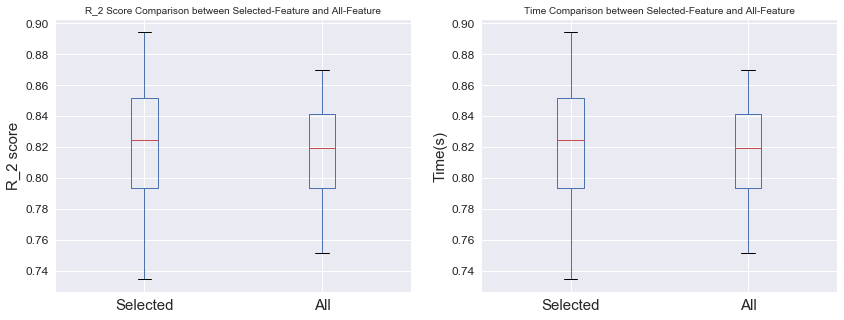

In [215]:
# Put the forest regressor score for all data and selected data in one dataframe
score_df2 = score_df.loc[:,['frst']]
score_df2.loc[:,'AllFeatures'] =frst_scores
score_df2.columns=['Selected','All']

time_df2 = time_df.loc[:,['frst']]
time_df2.loc[:,'All'] = frst_time
time_df2.columns=['Selected','All']

# make plot to compare the performance
fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
score_df2.boxplot()
plt.ylabel('R_2 score',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.title('R_2 Score Comparison between Selected-Feature and All-Feature',fontsize=10)

plt.subplot(1,2,2)
score_df2.boxplot()
plt.ylabel('Time(s)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.title('Time Comparison between Selected-Feature and All-Feature',fontsize=10)


`Selected` represents the performance of RandomForestRegressor with the **selected features** from data.

`All` represents the performance of RandomForestRegressor with **all the features** from data.

we can see that the median performance of `Selected` is a little better than `All`, but with **larger variance**, and more time consumption. 

### Result of RandomForestRegressor trained with selected features VS all features
From the boxplot above, it is hard to tell which one is better. `Selected feature` trained model give slightly better r_2 score that `All feature` trained model, but with a little larger variance. The time consumptions are also similar. For the stability and accuracy of the prediction, **we choose the `All Features` trained model**.


### 4.4 Tune the parameters of the RandomForestRegressor for best performance

In [222]:
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    score = r2_score(y_true, y_predict)
    return score

def fit_RandomForestRegressor(X, y):
    """ Performs grid search over the 'max_depth' and more parameter for a 
        random forest regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
#     cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)
    cv_sets = ShuffleSplit(n_splits=10, test_size = 0.20, random_state = 0)

    # TODO: Create a random forest regressor object
    regressor = RandomForestRegressor()
    
    ########### Defining Parameter Grid #############################################
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 80, stop = 120, num = 5)]
    
    # Number of features to consider at every split
#     max_features = ['auto', 'sqrt']
    max_features = ['auto']
    
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 25, num = 5)]
    
    # Minimum number of samples required to split a node,must be an integer greater than 1, or float <=1.
#     min_samples_split = [int(x) for x in np.linspace(2,10,num=9)]
    min_samples_split = [2]
    
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [int(x) for x in np.linspace(1,20,num=4)]
    
    # Method of selecting samples for training each tree
#     bootstrap = [True, False]
    bootstrap = [True]
    
    # This parameter tells the engine how many processors is it allowed to use. 
    #A value of “-1” means there is no restriction whereas a value of “1” means it can only use one processor.
    n_jobs = [-1]
    
    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 15
    params = {'n_estimators': n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_leaf':min_samples_leaf,
              'min_samples_split':min_samples_split,
              'n_jobs':n_jobs}
    #######################################################################################

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # TODO: Create the grid search object
    grid = GridSearchCV(regressor, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_,grid.best_score_
#     return grid


best_forest=fit_RandomForestRegressor(X_train,y_train)

print(best_forest)
score = r2_score(y_test,best_forest[0].predict(X_test))
print('Best_Forest Score:',score)

(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=110, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False), 0.8464022407728584)
Best_Forest Score: 0.8529372102870713


#### An explanation for the parameters tuned
- `n_estimators`: This is the number of trees you want to build before taking the maximum voting or averages of predictions. Higher number of trees give you better performance but makes your code slower. You should choose as high value as your processor can handle because this makes your predictions stronger and more stable.
- `max_depth`: Max number of levels in each decision tree. If set to None, all leaves are their purist or contain less samples than min_samples_split. 
- `min_samples_leaf`: Leaf is the end node of a decision tree. A smaller leaf makes the model more prone to capturing noise in train data

#### Save the trained model locally as 'best_forest.pkl'

In [223]:
from sklearn.externals import joblib
joblib.dump(best_forest[0], 'best_forest.pkl') 
# reg = joblib.load('best_forest.pkl') # Load it back

['best_forest.pkl']

In [224]:
from sklearn.externals import joblib
best_forest = joblib.load('best_forest.pkl') # Load it back
print(best_forest)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=110, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


### 4.5 Study the feature importace: what features contribute most to the model
What features are useful for our model, and what features are not. We will make a ranking for their importance, and make a plot for visulization for the top 20.

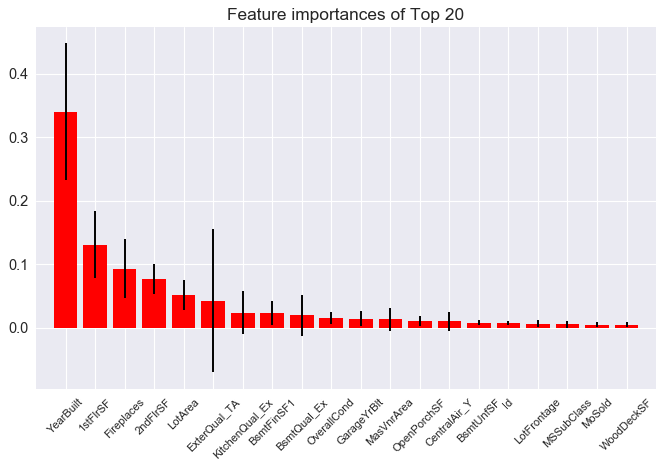

In [226]:
importances = best_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
feature_indices = X_train.columns[indices].tolist()

# Plot the feature importances of the forest
plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Feature importances of Top 20")
plt.bar(range(20), importances[indices][0:20],
       color="r", yerr=std[indices][0:20], align="center")
plt.xticks(range(20), feature_indices,rotation =45,fontsize=10)

plt.xlim([-1,20])
plt.fontsize=10

#### We should notice that the 16th important feature is `Id`, which is just the order of recording the data, and we know it has no correlation with house price at all. So we can consider `Id` and any feature that has less importance than `Id` to be not important.

#### Therefore, we use the first 15 features as the important features. We train the model with important features, and compare the the model trained with all features.

In [232]:
import time

forest = best_forest

# select important features
important_features = X_train.columns[indices].tolist()[0:15]
X_featured = X_train[important_features]

tic1 = time.clock()
forest_all = forest.fit(X_train,y_train)
toc1 = time.clock()
process_time1 = toc1-tic1
y_pred1 = forest_all.predict(X_test)
score_all=r2_score(y_test,y_pred1)


tic2 = time.clock()
forest_important = forest.fit(X_featured,y_train)
toc2 = time.clock()
process_time2 = toc2-tic2
y_pred2 = forest_important.predict(X_test[important_features])
score_important = r2_score(y_test, y_pred2)

print('Time for forest_all:',process_time1,'\nTime for forest_important:',process_time2)
print('Score_all:',score_all,'\nScore_important:',score_important)



Time for forest_all: 0.7110124072890471 
Time for forest_important: 0.33190821624381783
Score_all: 0.8518615614641304 
Score_important: 0.8529602241199411


#### Result: Model trained with only features is much more efficient, and have better performance.
| |All Features|Important Features|
|--|--|
|Training Time|0.7110 s|0.3319 s|
|Score|0.8518|0.8529|

- The model trained with only the 15 important features, used only half the time of model trained with all features
- Model with important features got score slightly better than model trained with all features.
#### Therefore, we choose only the important features for the final test

## Conclusion:
After studying the house price data set, we cleaned the data and processed it to for model training. A relative accurate model was trained, and tuned for the best performance. 

## 5. Test the model with the test data from the competition.

In [234]:
# import the test data, first preprocess the features to numeric values, and then trim it with to important features only
import numpy as np
from sklearn.cross_validation import train_test_split

def preprocess_features(X):
    '''   converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''

    # Initialize new output DataFrame(empty)
    output = pd.DataFrame(index = X.index)
     
    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        #print(col,col_data)

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
#             print(col,'categorical')
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

########### prepare test data ##########################################################
test_data = pd.read_csv('test.csv')
test_data = test_data.drop(['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'],1)
test_data = test_data.fillna(0)
X_for_test = preprocess_features(test_data)

############ Repeat model training and prediction for 50 times, and get the mean values
temp_dict={}
for i in range(50):
    model = best_forest.fit(X_all[important_features],y)
    y_pred= model.predict(X_for_test[important_features])
    temp_dict[i]=y_pred
temp_df = pd.DataFrame.from_dict(temp_dict)
y_pred_mean = temp_df.mean(axis=1)

############ save result to file for submission########################################
house_id = test_data.Id
sale_price = np.exp(y_pred_mean)

HousePrice = pd.DataFrame.from_dict({'Id':house_id,'SalePrice':sale_price}).set_index('Id')
HousePrice.to_csv(r'HousePrice.csv', header=True, index=True, sep=',', mode='a')

### Result:
The submission scored 0.15783. (Scaled from 1 to 0, where 0 is the best score), ranked 2860 out of 5118 participants.

[Click here for leaderboard on the webpage](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard)

## 6. Discussion
### 6.1 Data
- The dataset is from Ames, Iowa, so if we want to use the model for houses in other locations, we need to customize it to that city.
- Several features contain too many Nan values, and in some other features the `0` value is actually Nan as well.

### 6.2 Model 
- When we tuned the parameters in the RandomForestRegressor, grid search is performed at large steps. We can focus to the chosen values of the parameters from the first grid search, and focus on the small region around those value and do the gird search again with smaller grid step.
- Only three models are compared when we looked for the best model. We should do comparison among more models.
- We can also try some deep learning technique in future.